**Phase 0 : Imports and Reading Data:**

- Upload dataset.

- Import essential libraries: pandas, numpy, matplotlib, seaborn and....etc.

- Load the dataset into a DataFrame.

In [215]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import layers, models
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

In [216]:
df_train = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt'), sep=' ', header=None)
df_test = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt'), sep=' ', header=None)
rul = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt'), sep=' ', header=None)

**Phase 1: Data Understanding & Preprocessing**

- Explore dataset structure and dimensions.

- Assign column names, drop empty/constant columns.

- Check missing values and duplicates and handle.

- Verify data types and correct inconsistencies.

In [217]:
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)
rul.drop(rul.columns[[1]], axis=1, inplace=True)
print("df_train:" ,df_train.shape)
print("df_test:",df_test.shape)
print("rul:" ,rul.shape)

df_train: (61249, 26)
df_test: (41214, 26)
rul: (248, 1)


In [218]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names
df_train.columns = col_names
df_test.columns = col_names
rul.columns = ['RUL']

In [219]:
print(df_test.info())
print("---------------------------------")
print(df_train.info())
print("---------------------------------")
print(rul.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41214 entries, 0 to 41213
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   41214 non-null  int64  
 1   cycle                                    41214 non-null  int64  
 2   setting_1                                41214 non-null  float64
 3   setting_2                                41214 non-null  float64
 4   setting_3                                41214 non-null  float64
 5   (Fan inlet temperature) (◦R)             41214 non-null  float64
 6   (LPC outlet temperature) (◦R)            41214 non-null  float64
 7   (HPC outlet temperature) (◦R)            41214 non-null  float64
 8   (LPT outlet temperature) (◦R)            41214 non-null  float64
 9   (Fan inlet Pressure) (psia)              41214 non-null  float64
 10  (bypass-duct pressure) (psia)            41214

In [220]:
df_train.describe().transpose()

count         mean         std  \
engine                                   61249.0   124.325181   71.995350   
cycle                                    61249.0   134.311417   89.783389   
setting_1                                61249.0    23.999823   14.780722   
setting_2                                61249.0     0.571347    0.310703   
setting_3                                61249.0    94.031576   14.251954   
(Fan inlet temperature) (◦R)             61249.0   472.882435   26.436832   
(LPC outlet temperature) (◦R)            61249.0   579.420056   37.342647   
(HPC outlet temperature) (◦R)            61249.0  1417.896600  106.167598   
(LPT outlet temperature) (◦R)            61249.0  1201.915359  119.327591   
(Fan inlet Pressure) (psia)              61249.0     8.031626    3.622872   
(bypass-duct pressure) (psia)            61249.0    11.589457    5.444017   
(HPC outlet pressure) (psia)             61249.0   283.328633  146.880210   
(Physical fan speed) (rpm)               61249.0  2228.686034  145.348243   
(Physical core speed) (rpm)              61249.0  8524.673301  336.927547   
(Engine pressure ratio(P50/P2)           61249.0     1.096445    0.127681   
(HPC outlet Static pressure) (psia)      61249.0    42.874529    3.243492   
(Ratio of fuel flow to Ps30) (pps/psia)  61249.0   266.735665  138.479109   
(Corrected fan speed) (rpm)              61249.0  2334.427590  128.197859   
(Corrected core speed) (rpm)             61249.0  8067.811812   85.670543   
(Bypass Ratio)                           61249.0     9.285604    0.750374   
(Burner fuel-air ratio)                  61249.0     0.023252    0.004685   
(Bleed Enthalpy)                         61249.0   347.760029   27.808283   
(Required fan speed)                     61249.0  2228.613283  145.472491   
(Required fan conversion speed)          61249.0    97.751396    5.369424   
(High-pressure turbines Cool air flow)   61249.0    20.864333    9.936396   
(Low-pressure turbines Cool air flow)    61249.0    12.518995    5.962697   

                                               min        25%        50%  \
engine                                      1.0000    60.0000   126.0000   
cycle                                       1.0000    62.0000   123.0000   
setting_1                                   0.0000    10.0046    25.0014   
setting_2                                   0.0000     0.2507     0.7000   
setting_3                                  60.0000   100.0000   100.0000   
(Fan inlet temperature) (◦R)              445.0000   445.0000   462.5400   
(LPC outlet temperature) (◦R)             535.4800   549.3300   555.7400   
(HPC outlet temperature) (◦R)            1242.6700  1350.5500  1367.6800   
(LPT outlet temperature) (◦R)            1024.4200  1119.4900  1136.9200   
(Fan inlet Pressure) (psia)                 3.9100     3.9100     7.0500   
(bypass-duct pressure) (psia)               5.6700     5.7200     9.0300   
(HPC outlet pressure) (psia)              136.1700   142.9200   194.9600   
(Physical fan speed) (rpm)               1914.7200  2211.9500  2223.0700   
(Physical core speed) (rpm)              7984.5100  8320.5900  8362.7600   
(Engine pressure ratio(P50/P2)              0.9300     1.0200     1.0300   
(HPC outlet Static pressure) (psia)        36.0400    41.7600    42.3300   
(Ratio of fuel flow to Ps30) (pps/psia)   128.3100   134.5200   183.4500   
(Corrected fan speed) (rpm)              2027.5700  2387.9100  2388.0600   
(Corrected core speed) (rpm)             7845.7800  8062.6300  8083.8100   
(Bypass Ratio)                              8.1757     8.6480     9.2556   
(Burner fuel-air ratio)                     0.0200     0.0200     0.0200   
(Bleed Enthalpy)                          302.0000   330.0000   334.0000   
(Required fan speed)                     1915.0000  2212.0000  2223.0000   
(Required fan conversion speed)            84.9300   100.0000   100.0000   
(High-pressure turbines Cool air flow)     10.1600    10.9400  

In [221]:
df_train.duplicated().sum()

0

In [222]:
df_train.isnull().sum()

engine                                     0
cycle                                      0
setting_1                                  0
setting_2                                  0
setting_3                                  0
(Fan inlet temperature) (◦R)               0
(LPC outlet temperature) (◦R)              0
(HPC outlet temperature) (◦R)              0
(LPT outlet temperature) (◦R)              0
(Fan inlet Pressure) (psia)                0
(bypass-duct pressure) (psia)              0
(HPC outlet pressure) (psia)               0
(Physical fan speed) (rpm)                 0
(Physical core speed) (rpm)                0
(Engine pressure ratio(P50/P2)             0
(HPC outlet Static pressure) (psia)        0
(Ratio of fuel flow to Ps30) (pps/psia)    0
(Corrected fan speed) (rpm)                0
(Corrected core speed) (rpm)               0
(Bypass Ratio)                             0
(Burner fuel-air ratio)                    0
(Bleed Enthalpy)                           0
(Required 

**Phase 2: Exploratory Data Analysis (EDA)**
- Revealing the main features and distribution of the data.
- Uncover Relationships, identify correlations, and patterns between different variables.
- Detecting Outliers and unusual patterns are spotted, which can skew results if not addressed.  


**Feature engineering**: Calculate RUL column.

In [223]:
max_cycles_df = df_train.groupby('engine')['cycle'].max().reset_index()
max_cycles_df.columns = ['engine', 'max_cycles']
max_cycles_df
df_train = pd.merge(df_train, max_cycles_df, on='engine', how='left')

df_train['RUL'] = df_train['max_cycles'] - df_train['cycle']
df_train.drop(columns=['max_cycles'], inplace=True)
df_train

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    42.0049     0.8400      100.0   
1           1      2    20.0020     0.7002      100.0   
2           1      3    42.0038     0.8409      100.0   
3           1      4    42.0000     0.8400      100.0   
4           1      5    25.0063     0.6207       60.0   
...       ...    ...        ...        ...        ...   
61244     249    251     9.9998     0.2500      100.0   
61245     249    252     0.0028     0.0015      100.0   
61246     249    253     0.0029     0.0000      100.0   
61247     249    254    35.0046     0.8400      100.0   
61248     249    255    42.0030     0.8400      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            445.00                         549.68   
1                            491.19                         606.07   
2                            445.00                         548.95   
3                            445.00                         548.70   
4                            462.54                         536.10   
...                             ...                            ...   
61244                        489.05                         605.33   
61245                        518.67                         643.42   
61246                        518.67                         643.68   
61247                        449.44                         555.77   
61248                        445.00                         549.85   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1343.43                        1112.93   
1                            1477.61                        1237.50   
2                            1343.12                        1117.05   
3                            1341.24                        1118.03   
4                            1255.23                        1033.59   
...                              ...                            ...   
61244                        1516.36                        1315.28   
61245                        1598.92                        1426.77   
61246                        1607.72                        1430.56   
61247                        1381.29                        1148.18   
61248                        1369.75                        1147.45   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             3.91  ...                      2387.99   
1                             9.35  ...                      2387.73   
2                             3.91  ...                      2387.97   
3                             3.91  ...                      2388.02   
4                             7.05  ...                      2028.08   
...                            ...  ...                          ...   
61244                        10.52  ...                      2388.73   
61245                        14.62  ...                      2388.46   
61246                        14.62  ...                      2388.48   
61247                         5.48  ...                      2388.83   
61248                         3.91  ...                      2388.66   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8074.83           9.3335                     0.02   
1                           8046.13           9.1913                     0.02   
2                           8066.62           9.4007                     0.02   
3                           8076.05           9.3369                     0.02   
4                           7865.80          10.8366                     0.02   
...                             ...              ...                      ...   
61244                       8185.69           8.4541                     0.03   
61245                       8185.47           8.2221                     0.03   
61246                       8193.9

**Then**, Scale a copy of the train dataframe for visualization using MinMaxscaler().

In [224]:
scaler = MinMaxScaler()

df_copy= df_train.copy()
feature_cols = df_copy.columns.drop(['engine', 'cycle','RUL']).tolist()

df_copy[feature_cols] = scaler.fit_transform(df_copy[feature_cols])

df_copy

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1   0.999926   0.997625        1.0   
1           1      2   0.476147   0.831591        1.0   
2           1      3   0.999900   0.998694        1.0   
3           1      4   0.999810   0.997625        1.0   
4           1      5   0.595275   0.737173        0.0   
...       ...    ...        ...        ...        ...   
61244     249    251   0.238045   0.296912        1.0   
61245     249    252   0.000067   0.001781        1.0   
61246     249    253   0.000069   0.000000        1.0   
61247     249    254   0.833284   0.997625        1.0   
61248     249    255   0.999881   0.997625        1.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                          0.000000                       0.130347   
1                          0.626985                       0.647971   
2                          0.000000                       0.123646   
3                          0.000000                       0.121351   
4                          0.238089                       0.005691   
...                             ...                            ...   
61244                      0.597937                       0.641179   
61245                      1.000000                       0.990821   
61246                      1.000000                       0.993207   
61247                      0.060269                       0.186249   
61248                      0.000000                       0.131907   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                           0.272082                       0.212586   
1                           0.634407                       0.511781   
2                           0.271245                       0.222481   
3                           0.266168                       0.224835   
4                           0.033916                       0.022025   
...                              ...                            ...   
61244                       0.739044                       0.698595   
61245                       0.961980                       0.966374   
61246                       0.985742                       0.975477   
61247                       0.374315                       0.297250   
61248                       0.343153                       0.295497   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                         0.000000  ...                     0.993111   
1                         0.507937  ...                     0.992395   
2                         0.000000  ...                     0.993056   
3                         0.000000  ...                     0.993194   
4                         0.293184  ...                     0.001405   
...                            ...  ...                          ...   
61244                     0.617180  ...                     0.995150   
61245                     1.000000  ...                     0.994406   
61246                     1.000000  ...                     0.994462   
61247                     0.146592  ...                     0.995426   
61248                     0.000000  ...                     0.994958   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                          0.550773         0.400540                      0.0   
1                          0.481761         0.351346                      0.0   
2                          0.531031         0.423787                      0.0   
3                          0.553707         0.401716                      0.0   
4                          0.048140         0.920536                      0.0   
...                             ...              ...                      ...   
61244                      0.817347         0.096312                      1.0   
61245                      0.816818         0.016052                      1.0   
61246                      0.83718

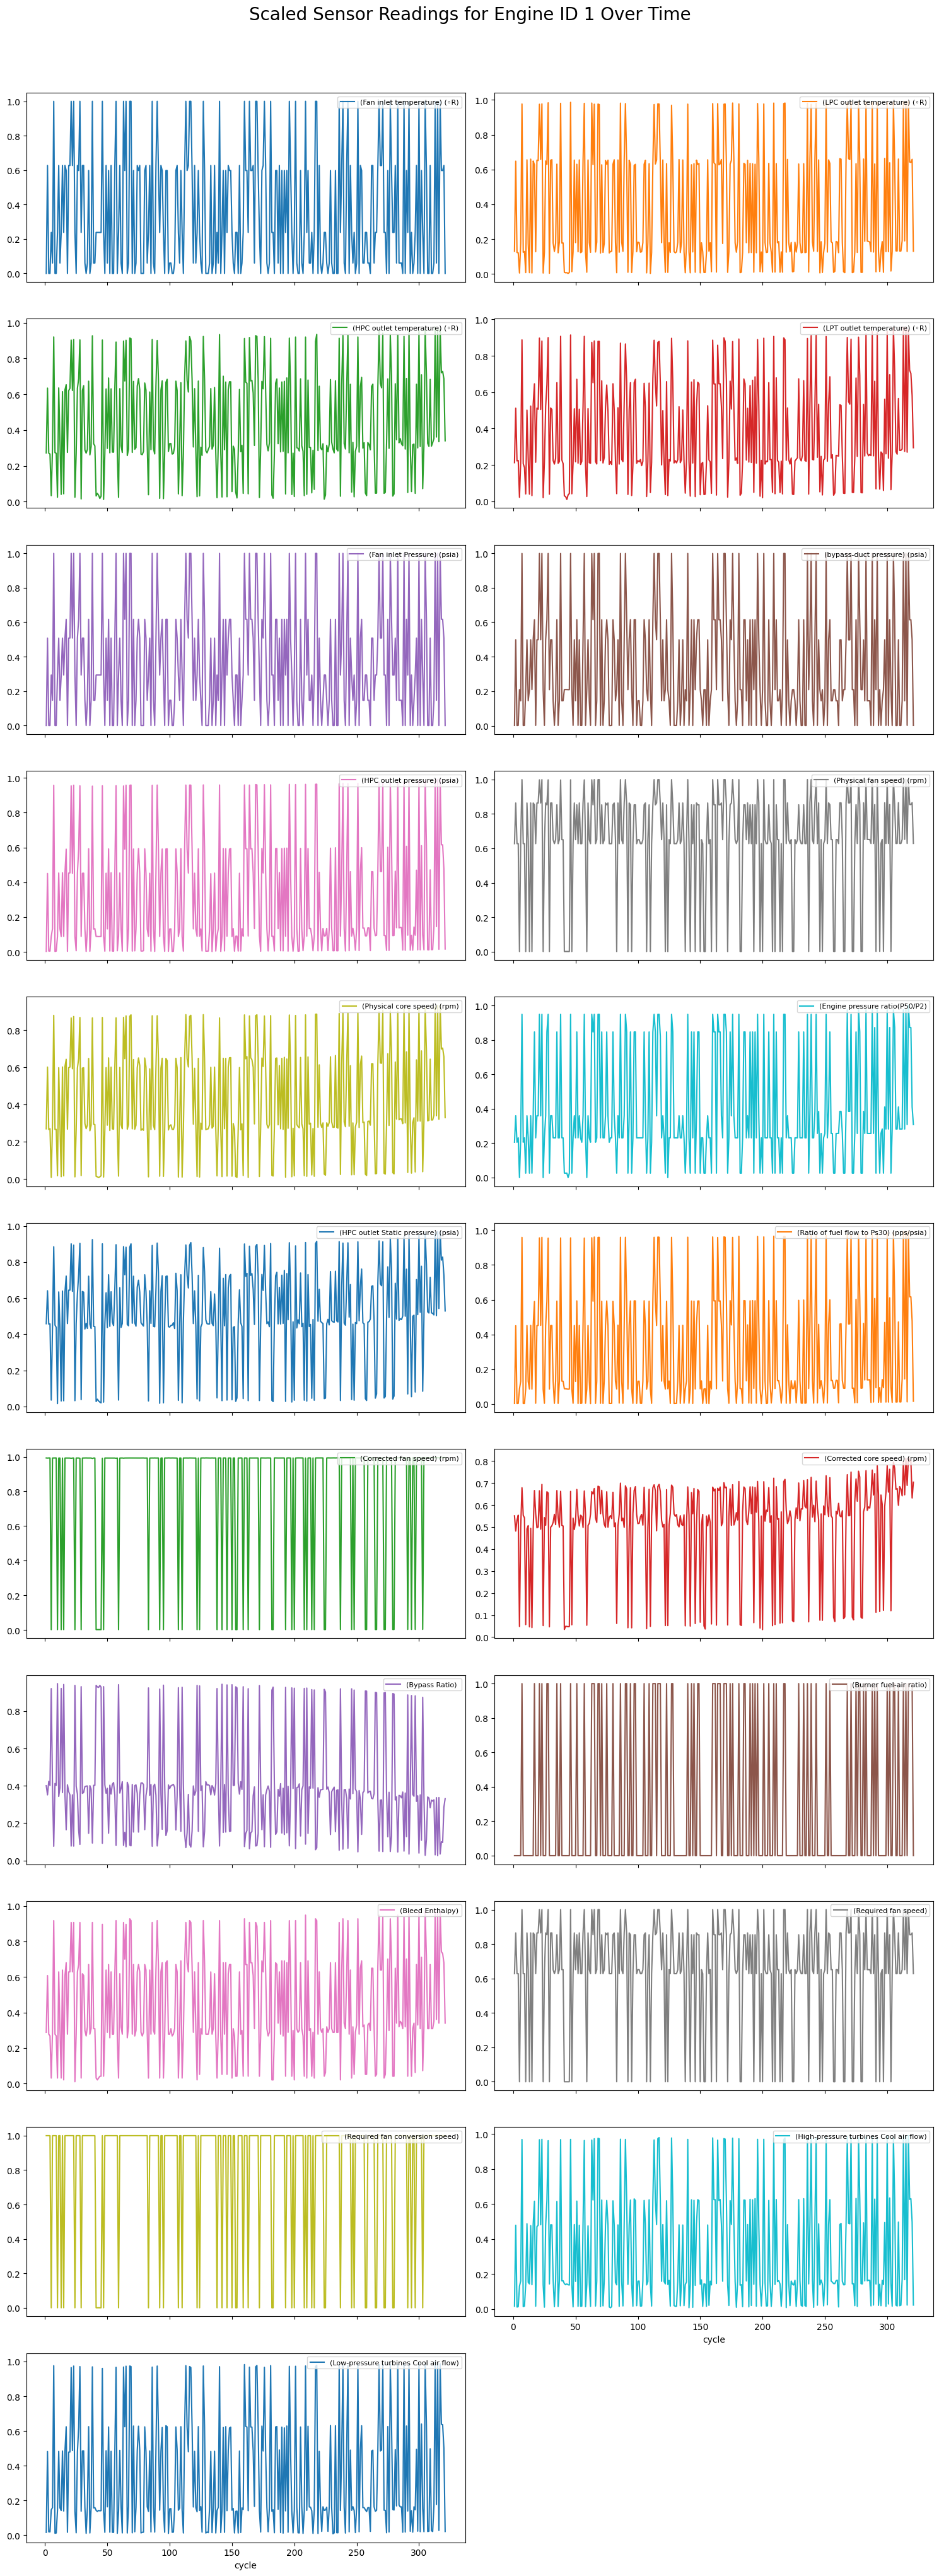

In [225]:

engine_to_plot = df_copy[df_copy['engine'] == 1]

sensors_to_plot = [ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
axes = engine_to_plot.plot(
    x='cycle', 
    y=sensors_to_plot, 
    subplots=True, 
    layout=(11, 2), 
    figsize=(15, 40), 
    legend=False)
plt.suptitle('Scaled Sensor Readings for Engine ID 1 Over Time', fontsize=20, y=1.02)

for ax, sensor in zip(axes.flatten(), sensors_to_plot):
    ax.legend([sensor], loc='upper right', fontsize=8)   

plt.tight_layout()
plt.show()

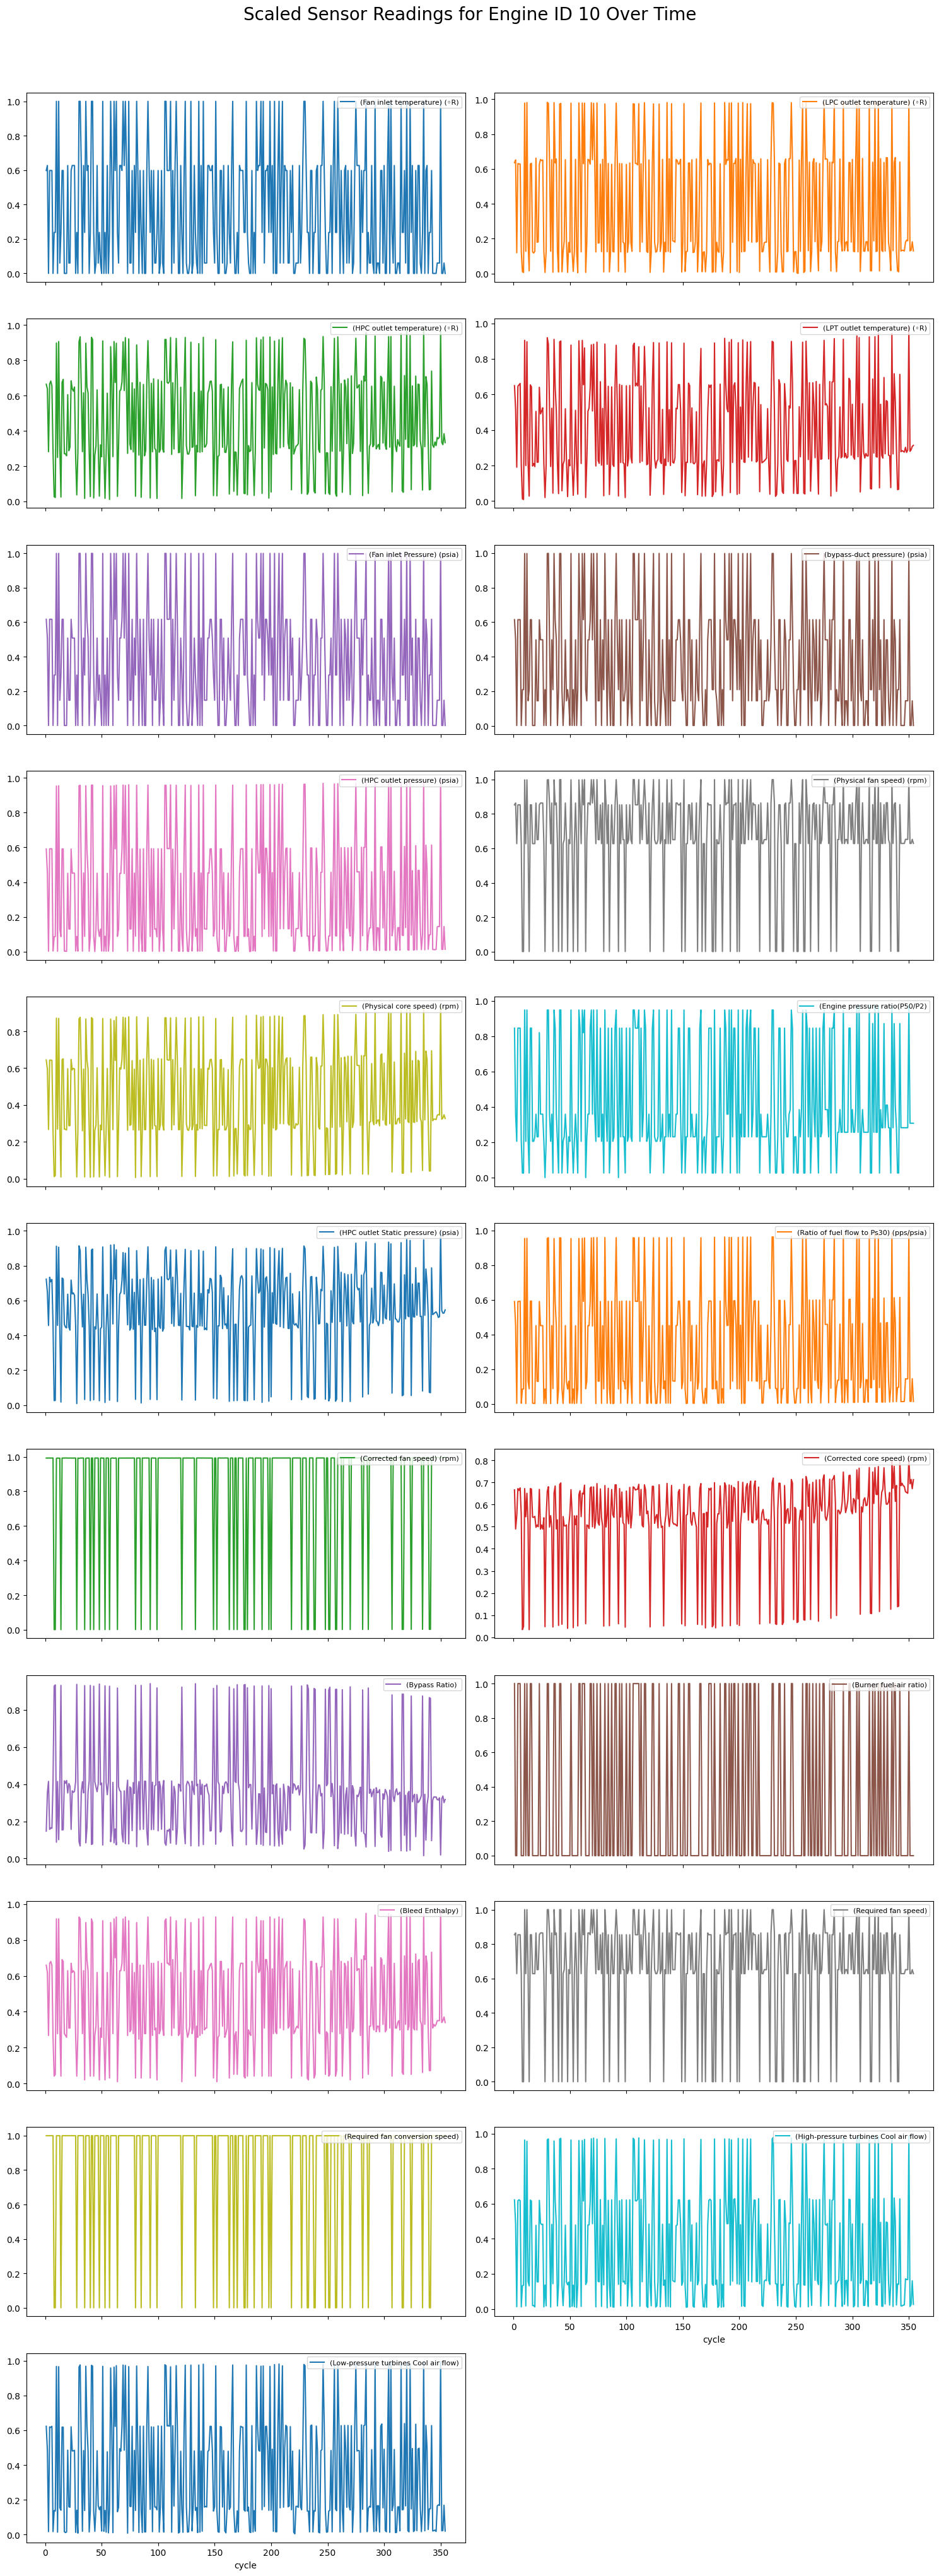

In [226]:
engine_to_plot = df_copy[df_copy['engine'] == 10]

sensors_to_plot = [ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
axes = engine_to_plot.plot(
    x='cycle', 
    y=sensors_to_plot, 
    subplots=True, 
    layout=(11, 2), 
    figsize=(15, 40), 
    legend=False)
plt.suptitle('Scaled Sensor Readings for Engine ID 10 Over Time', fontsize=20, y=1.02)

for ax, sensor in zip(axes.flatten(), sensors_to_plot):
    ax.legend([sensor], loc='upper right', fontsize=8)   

plt.tight_layout()
plt.show()

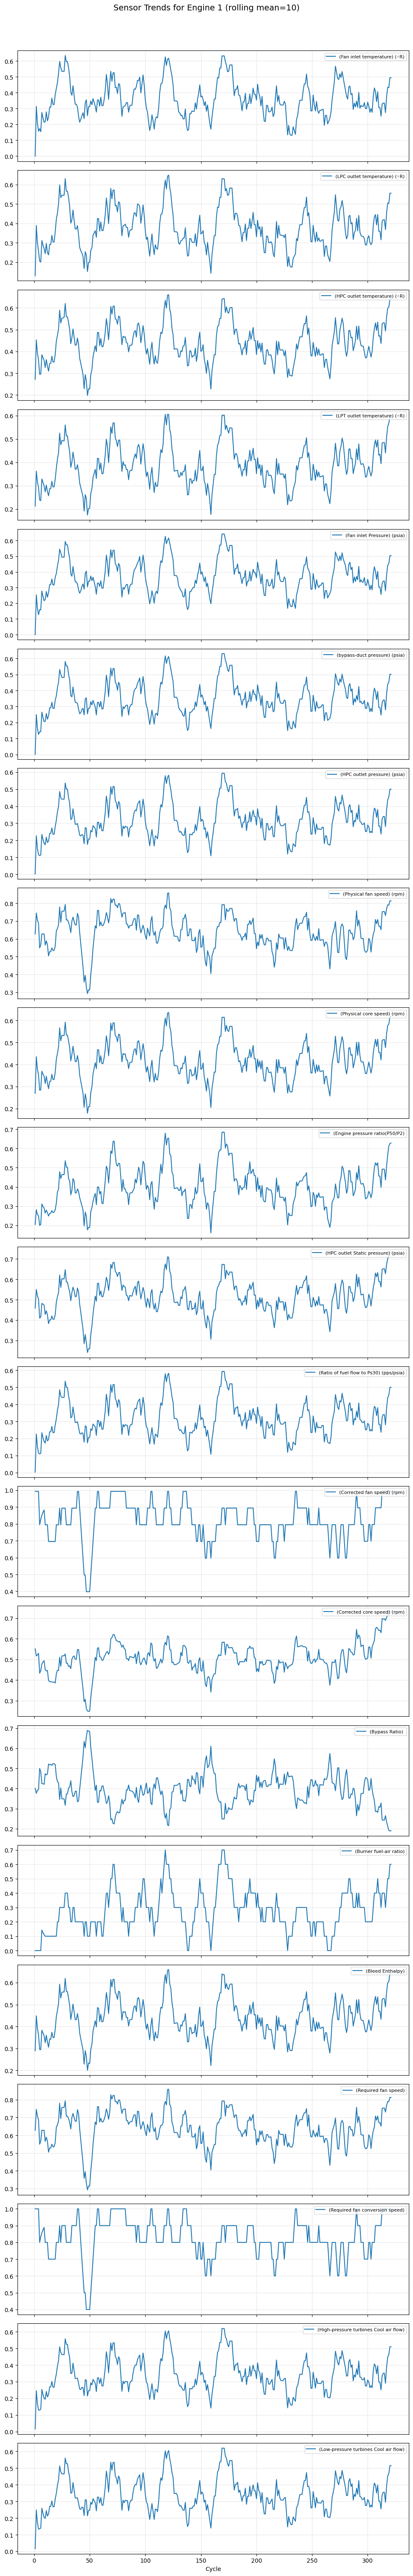

In [227]:
engine1_roll = engine1.copy()
engine1_roll[sensors_to_plot] = engine1[sensors_to_plot].rolling(window=10, min_periods=1).mean() 

n_sensors = len(sensors_to_plot)

fig, axes = plt.subplots(n_sensors, 1, figsize=(10, 3*n_sensors), sharex=True)

for ax, sensor in zip(axes, sensors_to_plot):
    ax.plot(engine1_roll['cycle'], engine1_roll[sensor], label=sensor)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle("Sensor Trends for Engine 1 (rolling mean=10)", fontsize=14)

fig.subplots_adjust(top=0.96)  
plt.xlabel("Cycle")
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()


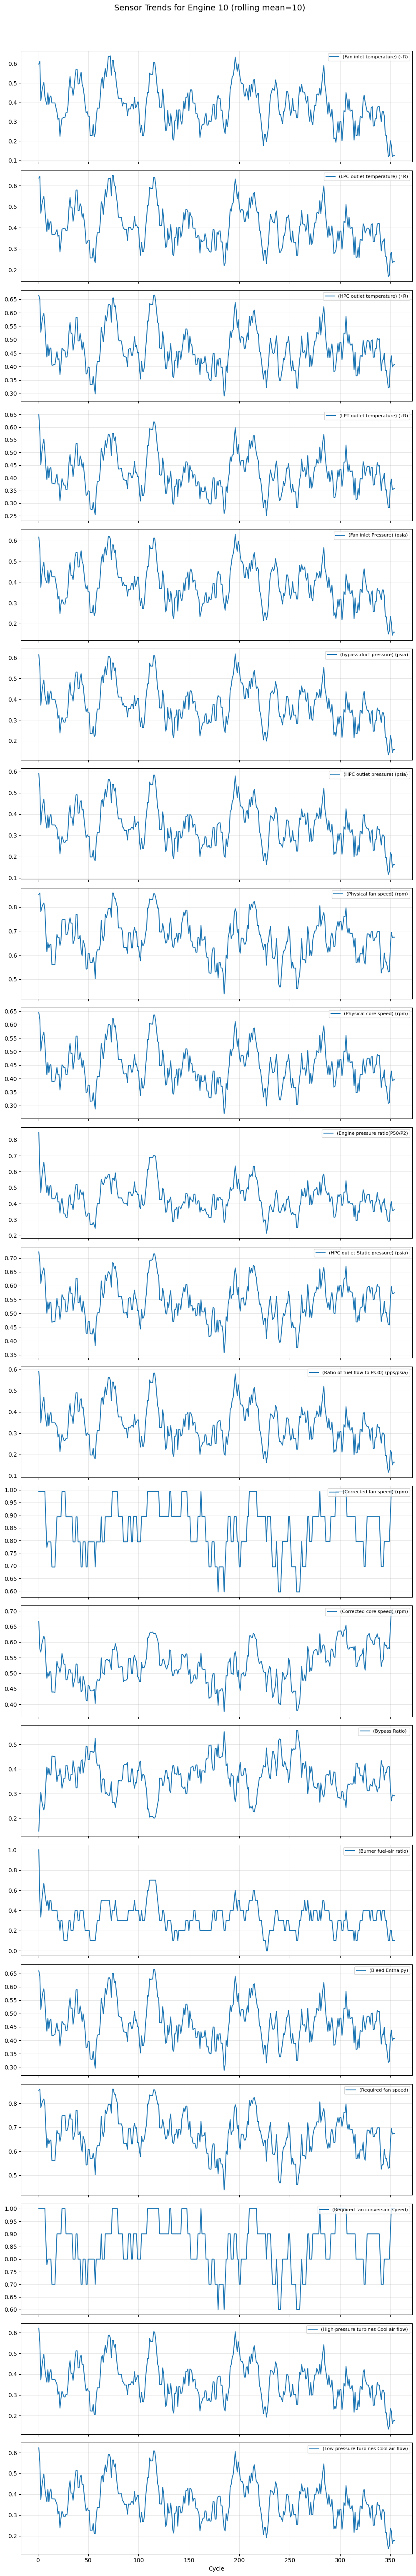

In [228]:
engine10 = df_copy[df_copy['engine']==10] 
engine10_roll[sensors_to_plot] = engine10[sensors_to_plot].rolling(window=10, min_periods=1).mean() 

n_sensors = len(sensors_to_plot)

fig, axes = plt.subplots(n_sensors, 1, figsize=(10, 3*n_sensors), sharex=True)

for ax, sensor in zip(axes, sensors_to_plot):
    ax.plot(engine10_roll['cycle'], engine10_roll[sensor], label=sensor)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle("Sensor Trends for Engine 10 (rolling mean=10)", fontsize=14)

fig.subplots_adjust(top=0.96)  
plt.xlabel("Cycle")
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()

**Initially,** the scaled sensor readings over engine cycles were plotted. These raw signals showed strong fluctuations and noise, making it difficult to directly extract meaningful patterns.

To improve interpretability, a rolling mean (window = 10) was applied to smooth the readings. This smoothing allowed the underlying trends to become more visible, highlighting gradual changes in engine behavior over time.

From the smoothed plots, several insights can be observed:

Some sensors (e.g., temperatures, pressures) show gradual upward or downward trends, which may indicate progressive wear or efficiency loss.

Other sensors fluctuate around relatively stable levels, suggesting they are less sensitive to degradation.

A few sensors show sharp shifts at certain cycles, which may correspond to operational changes or early warning signs of faults.

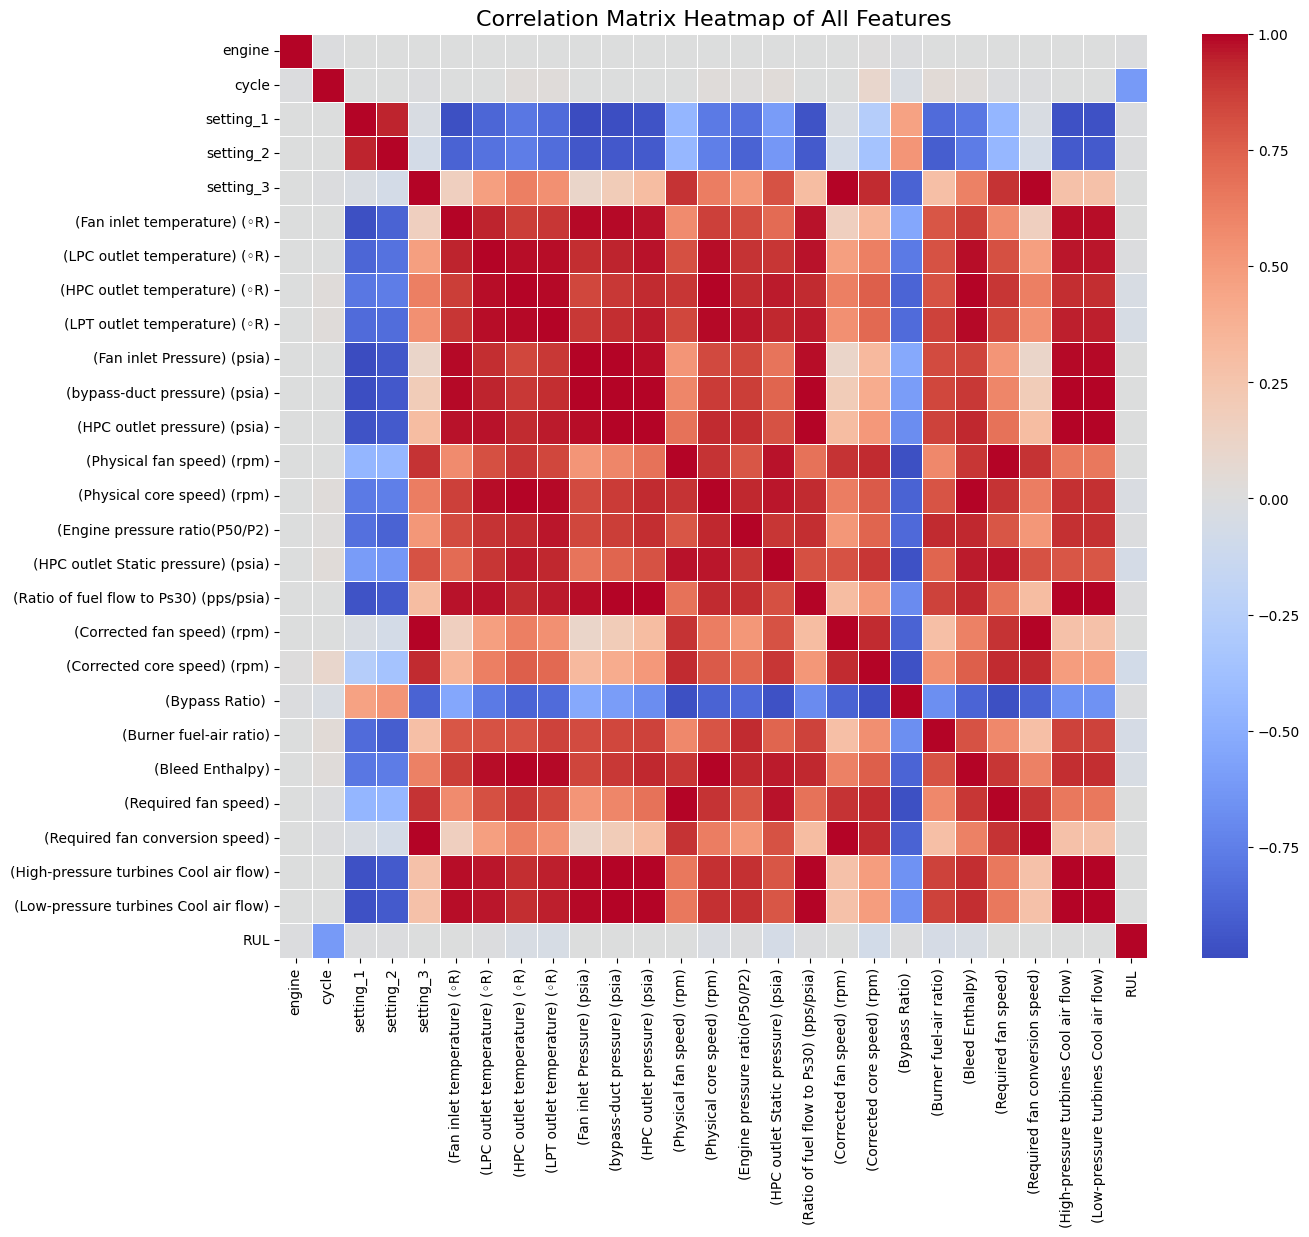

In [229]:
corr_matrix = df_copy.corr()

plt.figure(figsize=(14, 12))

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix Heatmap of All Features', fontsize=16)
plt.show()

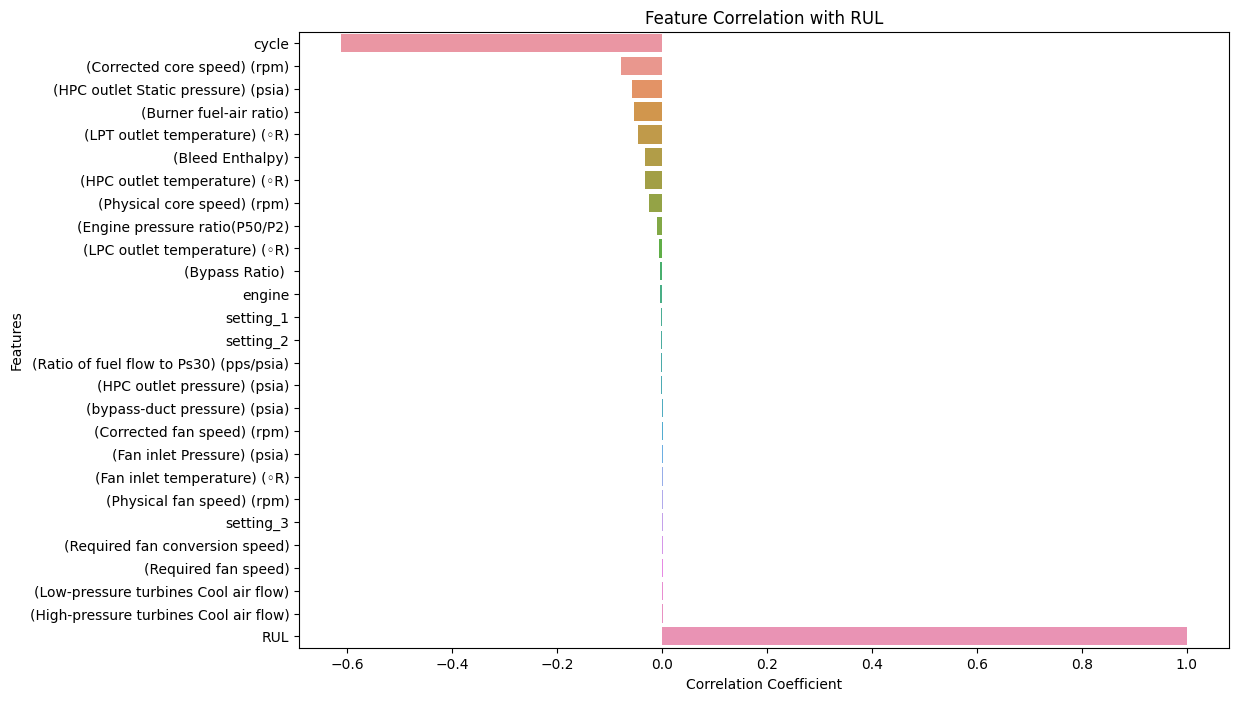

In [230]:
rul_correlations = corr_matrix['RUL'].sort_values(ascending=True)

plt.figure(figsize=(12, 8))

# Plot the correlations
sns.barplot(x=rul_correlations.values, y=rul_correlations.index)
plt.title('Feature Correlation with RUL')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

- The correlation heatmap shows strong positive correlation inside clear sensor groups (temperatures, pressures, speeds) — many sensors move together.

- A small set of features shows negative correlation with others (visible as blue bands), indicating different physical behavior or control settings.

- The RUL column displays noticeable correlation with a subset of sensors — some sensors trend together with remaining useful life.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


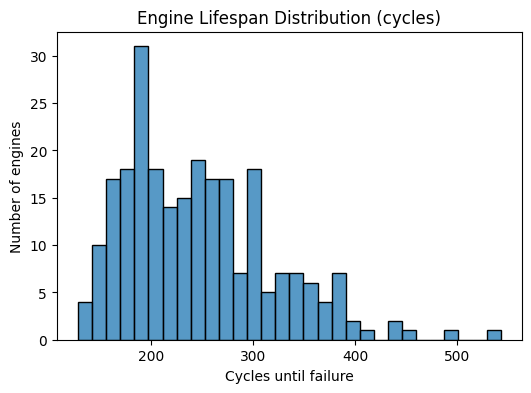

In [231]:
engine_cycles = df_copy.groupby('engine')['cycle'].max()  
plt.figure(figsize=(6,4))
sns.histplot(engine_cycles, bins=30, kde=False)   
plt.title("Engine Lifespan Distribution (cycles)")
plt.xlabel("Cycles until failure")
plt.ylabel("Number of engines")
plt.show()

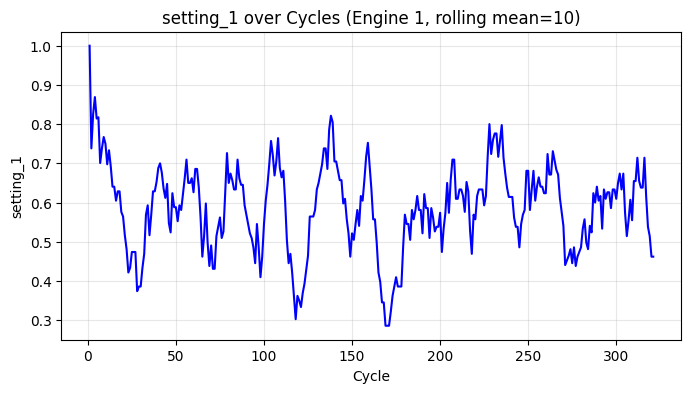

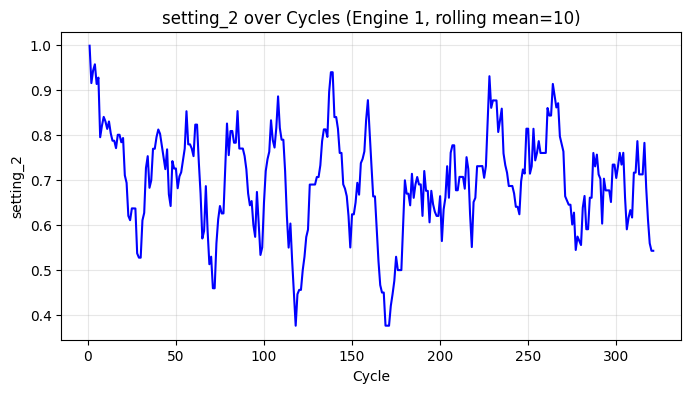

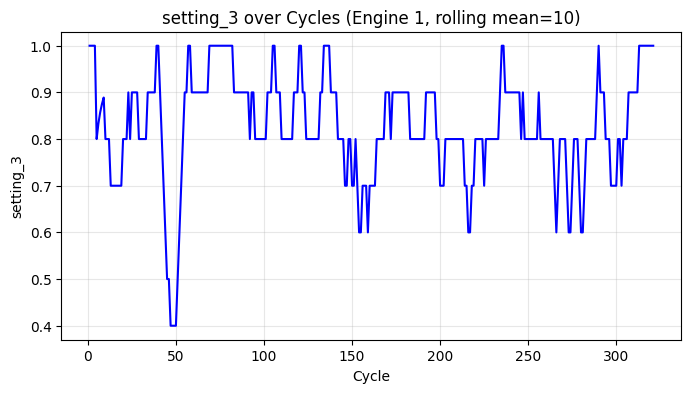

In [232]:
engine1_roll = engine1.copy()
for col in ['setting_1','setting_2','setting_3']:
    engine1_roll[col] = engine1[col].rolling(window=10, min_periods=1).mean()  

for col in ['setting_1','setting_2','setting_3']:
    plt.figure(figsize=(8,4))
    plt.plot(engine1['cycle'], engine1_roll[col], color='blue')
    plt.title(f"{col} over Cycles (Engine 1, rolling mean=10)")
    plt.xlabel("Cycle")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.show()

Settings 1 and 2 provide more informative degradation signals as they decrease with engine cycles, making them potentially useful predictors for RUL estimation. Setting 3 is less directly correlated with time, but may still add value in combination with other sensors.

In [233]:
RUL_CLIP_VALUE = 125

df_copy['RUL'] = df_copy['RUL'].clip(upper=RUL_CLIP_VALUE)

print(f"RUL values have been clipped at a maximum of {RUL_CLIP_VALUE}.")

RUL values have been clipped at a maximum of 125.


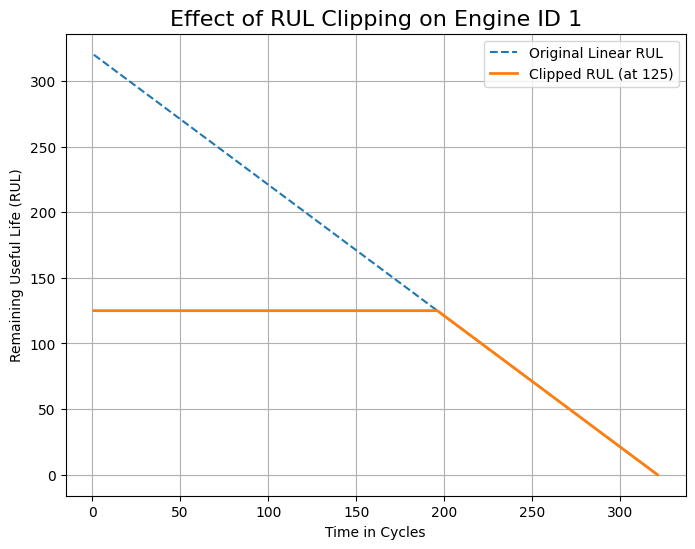

In [234]:
engine_to_plott = df_copy[df_copy['engine'] == 1].copy()
max_cycles_engine_1 = engine_to_plott['cycle'].max()
original_rul = max_cycles_engine_1 - engine_to_plott['cycle']


plt.figure(figsize=(8, 6))
plt.plot(engine_to_plott['cycle'], original_rul, label='Original Linear RUL', linestyle='--')
plt.plot(engine_to_plott['cycle'], engine_to_plott['RUL'], label=f'Clipped RUL (at {RUL_CLIP_VALUE})', linewidth=2)

plt.title('Effect of RUL Clipping on Engine ID 1', fontsize=16)
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

Clipping helps prevent very high RUL values at early stages from dominating the learning process. This makes the prediction task more stable and focuses the model on the degradation phase closer to failure.


----------------------------------------------------------

Unlike traditional datasets where outliers may represent noise, in predictive maintenance datasets such as C-MAPSS, extreme sensor values often carry critical information about degradation. Therefore, instead of removing outliers, we apply feature scaling (standardization/normalization) to make training more stable.


----------------------


**Phase 3: Prepare Data for Prime Time**

- Splitting data into training and testing sets.
- Standardizing the features to ensure all variables are on the same scale.

In [235]:
max_cycles_df = df_test.groupby('engine')['cycle'].max().reset_index()
max_cycles_df.columns = ['engine', 'max_cycles']
df_test = pd.merge(df_test, max_cycles_df, on='engine', how='left')
df_test['RUL'] = df_test['max_cycles'] - df_test['cycle']
df_test.drop(columns=['max_cycles'], inplace=True)
rul['engine']=rul.index+1
rul=rul[['engine','RUL']]
rul_dict = rul.set_index('engine')['RUL'].to_dict()
df_test['RUL'] = df_test['RUL'] + df_test['engine'].map(rul_dict)
df_test

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    20.0072     0.7000      100.0   
1           1      2    24.9984     0.6200       60.0   
2           1      3    42.0000     0.8420      100.0   
3           1      4    42.0035     0.8402      100.0   
4           1      5    35.0079     0.8400      100.0   
...       ...    ...        ...        ...        ...   
41209     248    277    41.9991     0.8401      100.0   
41210     248    278    20.0026     0.7005      100.0   
41211     248    279    34.9988     0.8413      100.0   
41212     248    280    20.0027     0.7000      100.0   
41213     248    281    35.0075     0.8402      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            491.19                         606.67   
1                            462.54                         536.22   
2                            445.00                         549.23   
3                            445.00                         549.19   
4                            449.44                         555.10   
...                             ...                            ...   
41209                        445.00                         550.30   
41210                        491.19                         608.00   
41211                        449.44                         555.92   
41212                        491.19                         608.19   
41213                        449.44                         556.40   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1481.04                        1227.81   
1                            1256.17                        1031.48   
2                            1340.13                        1105.88   
3                            1339.70                        1107.26   
4                            1353.04                        1117.80   
...                              ...                            ...   
41209                        1364.40                        1129.17   
41210                        1494.75                        1260.88   
41211                        1370.65                        1130.97   
41212                        1489.11                        1256.25   
41213                        1378.58                        1140.70   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             9.35  ...                      2387.78   
1                             7.05  ...                      2028.09   
2                             3.91  ...                      2387.95   
3                             3.91  ...                      2387.90   
4                             5.48  ...                      2387.87   
...                            ...  ...                          ...   
41209                         3.91  ...                      2388.50   
41210                         9.35  ...                      2388.33   
41211                         5.48  ...                      2388.64   
41212                         9.35  ...                      2388.37   
41213                         5.48  ...                      2388.59   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8048.98           9.2229                     0.02   
1                           7863.46          10.8632                     0.02   
2                           8071.13           9.3960                     0.02   
3                           8078.89           9.3594                     0.02   
4                           8057.83           9.3030                     0.02   
...                             ...              ...                      ...   
41209                       8112.61           9.4427                     0.02   
41210                       8086.83           9.2772                     0.02   
41211                       8100.8

In [236]:
RUL_CLIP_VALUE = 125

df_train['RUL'] = df_train['RUL'].clip(upper=RUL_CLIP_VALUE)

print(f"RUL values have been clipped at a maximum of {RUL_CLIP_VALUE}.")
df_train

RUL values have been clipped at a maximum of 125.


engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    42.0049     0.8400      100.0   
1           1      2    20.0020     0.7002      100.0   
2           1      3    42.0038     0.8409      100.0   
3           1      4    42.0000     0.8400      100.0   
4           1      5    25.0063     0.6207       60.0   
...       ...    ...        ...        ...        ...   
61244     249    251     9.9998     0.2500      100.0   
61245     249    252     0.0028     0.0015      100.0   
61246     249    253     0.0029     0.0000      100.0   
61247     249    254    35.0046     0.8400      100.0   
61248     249    255    42.0030     0.8400      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            445.00                         549.68   
1                            491.19                         606.07   
2                            445.00                         548.95   
3                            445.00                         548.70   
4                            462.54                         536.10   
...                             ...                            ...   
61244                        489.05                         605.33   
61245                        518.67                         643.42   
61246                        518.67                         643.68   
61247                        449.44                         555.77   
61248                        445.00                         549.85   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1343.43                        1112.93   
1                            1477.61                        1237.50   
2                            1343.12                        1117.05   
3                            1341.24                        1118.03   
4                            1255.23                        1033.59   
...                              ...                            ...   
61244                        1516.36                        1315.28   
61245                        1598.92                        1426.77   
61246                        1607.72                        1430.56   
61247                        1381.29                        1148.18   
61248                        1369.75                        1147.45   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             3.91  ...                      2387.99   
1                             9.35  ...                      2387.73   
2                             3.91  ...                      2387.97   
3                             3.91  ...                      2388.02   
4                             7.05  ...                      2028.08   
...                            ...  ...                          ...   
61244                        10.52  ...                      2388.73   
61245                        14.62  ...                      2388.46   
61246                        14.62  ...                      2388.48   
61247                         5.48  ...                      2388.83   
61248                         3.91  ...                      2388.66   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8074.83           9.3335                     0.02   
1                           8046.13           9.1913                     0.02   
2                           8066.62           9.4007                     0.02   
3                           8076.05           9.3369                     0.02   
4                           7865.80          10.8366                     0.02   
...                             ...              ...                      ...   
61244                       8185.69           8.4541                     0.03   
61245                       8185.47           8.2221                     0.03   
61246                       8193.9

In [237]:
X = df_train.drop(columns=["engine", "cycle", "RUL"])
y = df_train["RUL"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler=StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_val_s=scaler.transform(X_val)

**Phase 4: Model Building and Training**

- Build and train multiple models:

   - XGBoost Regressor

   - Random Forest Regressor

   - LightGBM Regressor

   - LSTM

   - CatBoost Regressor

- Evaluated and compared model performance through detailed reports to identify the most suitable model for deployment and prediction. 

In [238]:
model_xgb = xgb.XGBRegressor(
    n_estimators=200,     
    max_depth=5,          
    learning_rate=0.1,    
    subsample=0.8,        
    colsample_bytree=0.8, 
    random_state=42
)

model_xgb.fit(X_train_s, y_train)

y_pred_xgb = model_xgb.predict(X_val_s)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"Validation RMSE: {rmse_xgb:.2f}")
print(f"Validation MAE: {mae_xgb:.2f}")
print(f"Validation R2 Score: {r2_xgb:.2f}")


Validation RMSE: 17.40
Validation MAE: 11.94
Validation R2 Score: 0.82


In [239]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_s, y_train)
y_pred_rf = rf_model.predict(X_val_s)
r2_rf= r2_score(y_val, y_pred_rf)

print("RF RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("RF MAE:", mean_absolute_error(y_val, y_pred_rf))
print("RF R2:", r2_score(y_val, y_pred_rf))



RF RMSE: 17.264580627016787
RF MAE: 12.141144609773503
RF R2: 0.8198982289637791


In [241]:
lgb = LGBMRegressor(n_estimators=200, 
                    learning_rate=0.05,
                    num_leaves=31)  
lgb.fit(X_train_s, y_train)                  
y_pred_lgb = lgb.predict(X_val_s) 
r2_lgb= r2_score(y_val, y_pred_lgb)

print("LGBM RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lgb)))
print("LGBM MAE:", mean_absolute_error(y_val, y_pred_lgb))
print(f"Validation R2 Score: {r2_lgb:.2f}")
from lightgbm import LGBMRegressor, early_stopping, log_evaluation



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 48999, number of used features: 24
[LightGBM] [Info] Start training from score 92.882365
LGBM RMSE: 17.563654302525194
LGBM MAE: 12.102966819895368
Validation R2 Score: 0.81


In [243]:
X_train_seq = np.expand_dims(X_train_s, axis=1)
X_val_seq  = np.expand_dims(X_val_s, axis=1)

model_lstm = models.Sequential()
model_lstm.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True),
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
))
model_lstm.add(layers.Dropout(0.3))
model_lstm.add(layers.LSTM(32))
model_lstm.add(layers.BatchNormalization())
model_lstm.add(layers.Dense(64, activation='relu'))
model_lstm.add(layers.Dense(1))

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callback],
    verbose=2
)

y_pred_lstm = model_lstm.predict(X_val_seq).reshape(-1)

print("LSTM RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lstm)))
print("LSTM MAE:", mean_absolute_error(y_val, y_pred_lstm))
print("LSTM R2:", r2_score(y_val, y_pred_lstm))


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1225/1225 - 16s - 13ms/step - loss: 2931.9934 - val_loss: 703.1578
Epoch 2/100
1225/1225 - 6s - 5ms/step - loss: 903.4324 - val_loss: 542.0238
Epoch 3/100
1225/1225 - 6s - 5ms/step - loss: 830.2905 - val_loss: 531.5172
Epoch 4/100
1225/1225 - 6s - 5ms/step - loss: 753.5433 - val_loss: 471.0602
Epoch 5/100
1225/1225 - 6s - 5ms/step - loss: 725.8417 - val_loss: 461.8277
Epoch 6/100
1225/1225 - 6s - 5ms/step - loss: 630.1656 - val_loss: 457.8705
Epoch 7/100
1225/1225 - 6s - 5ms/step - loss: 573.9479 - val_loss: 528.8679
Epoch 8/100
1225/1225 - 6s - 5ms/step - loss: 529.7766 - val_loss: 432.4930
Epoch 9/100
1225/1225 - 6s - 5ms/step - loss: 502.3694 - val_loss: 453.0017
Epoch 10/100
1225/1225 - 6s - 5ms/step - loss: 487.8766 - val_loss: 449.3995
Epoch 11/100
1225/1225 - 6s - 5ms/step - loss: 480.9975 - val_loss: 459.4680
Epoch 12/100
1225/1225 - 6s - 5ms/step - loss: 471.6912 - val_loss: 408.5289
Epoch 13/100
1225/1225 - 6s - 5ms/step - loss: 465.3251 - val_loss: 414.8904
Epoch 14/100
1225

In [244]:
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(X_train_s, y_train, verbose=100)
y_pred_cb = model_cb.predict(X_val_s)
r2_cb= r2_score(y_val, y_pred_cb)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cb)))
print("CatBoost MAE:", mean_absolute_error(y_val, y_pred_cb))
print(f"Validation R2 Score: {r2_cb:.2f}")

Learning rate set to 0.075723
0:	learn: 38.9228067	total: 16.8ms	remaining: 16.8s
100:	learn: 18.8059956	total: 793ms	remaining: 7.05s
200:	learn: 17.7289801	total: 1.59s	remaining: 6.32s
300:	learn: 17.2189944	total: 2.33s	remaining: 5.4s
400:	learn: 16.8707843	total: 3.05s	remaining: 4.55s
500:	learn: 16.6033289	total: 3.77s	remaining: 3.75s
600:	learn: 16.3805212	total: 4.49s	remaining: 2.98s
700:	learn: 16.1722130	total: 5.21s	remaining: 2.22s
800:	learn: 15.9863121	total: 5.93s	remaining: 1.47s
900:	learn: 15.8111833	total: 6.66s	remaining: 732ms
999:	learn: 15.6518125	total: 7.38s	remaining: 0us
CatBoost RMSE: 17.190783461089676
CatBoost MAE: 11.733080863828851
Validation R2 Score: 0.82


In [246]:
final_comparison_data = {
    'Metric': ['RMSE', 'MEA', 'R-squared'],
    'XGBRegressor': [rmse_xgb ,mae_xgb ,r2_xgb],
    'Random forest': [rmse_rf, mae_rf, r2_rf],
    'LGBMRegressor':[np.sqrt(mean_squared_error(y_val, y_pred_lgb)), mean_absolute_error(y_val, y_pred_lgb), r2_lgb],
    'LSTM': [np.sqrt(mean_squared_error(y_val, y_pred_lstm)),mean_absolute_error(y_val, y_pred_lstm),r2_score(y_val, y_pred_lstm)],  
    'CatBoost': [np.sqrt(mean_squared_error(y_val, y_pred_cb)),mean_absolute_error(y_val, y_pred_cb),r2_cb]
}

final_comparison_df = pd.DataFrame(final_comparison_data)

final_comparison_df.set_index('Metric', inplace=True)

print("Final Performance Comparison on the Test Set:")
display(final_comparison_df.round(2))


Final Performance Comparison on the Test Set:


XGBRegressor  Random forest  LGBMRegressor   LSTM  CatBoost
Metric                                                                
RMSE              17.40          17.55          17.56  18.88     17.19
MEA               11.94          12.11          12.10  13.51     11.73
R-squared          0.82           0.82           0.81   0.78      0.82

In [247]:
def regression_report(model, X_train, y_train, X_val, y_val, name="Model"):

    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)

    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    r2_val = r2_score(y_val, y_pred_val)

    report = pd.DataFrame({
        "Dataset": ["Train", "Validation"],
        "RMSE": [rmse_train, rmse_val],
        "MAE": [mae_train, mae_val],
        "R2": [r2_train, r2_val]
    })
    print(f"\n{name} Report:\n", report)
    return report


regression_report(model_xgb, X_train_s, y_train, X_val_s, y_val, "XGBoost")
regression_report(rf_model, X_train_s, y_train, X_val_s, y_val, "RandomForest")
regression_report(lgb, X_train_s, y_train, X_val_s, y_val, "LightGBM")
regression_report(model_cb, X_train_s, y_train, X_val_s, y_val, "CatBoost")


y_pred_train_lstm = model_lstm2.predict(X_train_seq).reshape(-1)
y_pred_val_lstm = model_lstm2.predict(X_val_seq).reshape(-1)

report_lstm = pd.DataFrame({
    "Dataset": ["Train", "Validation"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_pred_train_lstm)),
        np.sqrt(mean_squared_error(y_val, y_pred_val_lstm))
    ],
    "MAE": [
        mean_absolute_error(y_train, y_pred_train_lstm),
        mean_absolute_error(y_val, y_pred_val_lstm)
    ],
    "R2": [
        r2_score(y_train, y_pred_train_lstm),
        r2_score(y_val, y_pred_val_lstm)
    ]
})

print("\nLSTM Report:\n", report_lstm)


XGBoost Report:
       Dataset       RMSE        MAE        R2
0       Train  16.213417  11.118091  0.840993
1  Validation  17.404254  11.938466  0.816972

RandomForest Report:
       Dataset       RMSE        MAE        R2
0       Train   6.576749   4.608954  0.973837
1  Validation  17.264581  12.141145  0.819898

LightGBM Report:
       Dataset       RMSE        MAE        R2
0       Train  16.691773  11.495601  0.831472
1  Validation  17.563654  12.102967  0.813604

CatBoost Report:
       Dataset       RMSE        MAE        R2
0       Train  15.651813  10.675042  0.851818
1  Validation  17.190783  11.733081  0.821435
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM Report:
       Dataset       RMSE        MAE        R2
0       Train  19.175542  13.483196  0.777586
1  Validation  19.008025  13.478224  0.781687


Based on the evaluation results, **CatBoost Regressor was selected as the final model**. It achieved the best balance between training and validation performance, with relatively low RMSE and MAE, and the highest R² score on the validation set (0.82). While other models such as Random Forest showed strong performance on the training set, they suffered from overfitting. After experimenting with multiple approaches, CatBoost provided the most reliable and consistent results, making it the most suitable choice for deployment.

**Phase 5: Launch the predicive RUL model! (CatBoost Regressor)**

In [207]:
df_test.iloc[41209]

engine                                      248.0000
cycle                                       277.0000
setting_1                                    41.9991
setting_2                                     0.8401
setting_3                                   100.0000
(Fan inlet temperature) (◦R)                445.0000
(LPC outlet temperature) (◦R)               550.3000
(HPC outlet temperature) (◦R)              1364.4000
(LPT outlet temperature) (◦R)              1129.1700
(Fan inlet Pressure) (psia)                   3.9100
(bypass-duct pressure) (psia)                 5.7200
(HPC outlet pressure) (psia)                138.3400
(Physical fan speed) (rpm)                 2212.3500
(Physical core speed) (rpm)                8351.7300
(Engine pressure ratio(P50/P2)                1.0200
(HPC outlet Static pressure) (psia)          42.3000
(Ratio of fuel flow to Ps30) (pps/psia)     130.8700
(Corrected fan speed) (rpm)                2388.5000
(Corrected core speed) (rpm)               811

In [214]:
new_sensor_reading = {
"setting_1":41.9991,
"setting_2":0.8401,
"setting_3":100.0000,
"(Fan inlet temperature) (◦R)":445.0000,
"(LPC outlet temperature) (◦R)" :550.3000,
"(HPC outlet temperature) (◦R)":1364.4000,
"(LPT outlet temperature) (◦R)":1129.1700,
"(Fan inlet Pressure) (psia)":3.9100,
"(bypass-duct pressure) (psia)":5.7200,
"(HPC outlet pressure) (psia)":138.3400,
"(Physical fan speed) (rpm)":2212.3500,
"(Physical core speed) (rpm)":8351.7300,
"(Engine pressure ratio(P50/P2)":1.0200,
"(HPC outlet Static pressure) (psia)":42.3000,
"(Ratio of fuel flow to Ps30) (pps/psia)":130.8700,
"(Corrected fan speed) (rpm)":2388.5000,
"(Corrected core speed) (rpm)":8112.6100,
"(Bypass Ratio) ":9.4427,
"(Burner fuel-air ratio)":0.0200,
"(Bleed Enthalpy)":331.0000,
"(Required fan speed)":2212.0000,
"(Required fan conversion speed)":100.0000,
"(High-pressure turbines Cool air flow)":10.5300,
"(Low-pressure turbines Cool air flow)":6.2620
    # RUL = 30 
}

sensor_data = pd.DataFrame([new_sensor_reading])
sensor_data = sensor_data[X_train.columns]
sensor_data = scaler.transform(sensor_data)
sensor_data_df= pd.DataFrame(sensor_data, columns=X_train.columns)

rul_pred = model_cb.predict(sensor_data_df)

print(f"Predicted RUL: {int(rul_pred[0])}")

Predicted RUL: 32


The CatBoost model achieved good accuracy, as its predictions were very close to the true RUL values (e.g., predicting 124 instead of 125, and 32 instead of 30).